Here all nodes of the "Flower" class are honest, the strategic one is implicit as it performs a gradient attack (it doesnt need any data nor model)

# INITIALISATION

In [1]:
from time import time
import os
import shutil
import random
from copy import deepcopy
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image, resize, to_tensor

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
DEFAULTS = {
            "w": 1,   # float >= 0, harmonisation parameter
            "lr_gen": 0.02,     # float > 0, learning rate of global model
            "lr_node": 0.02,    # float > 0, learning rate of local models
            "NN" : 'linear',     # "base" or "conv", neural network architecture
            "opt": optim.Adam,    # any torch optimizer
            "pow_gen": (2, 1),  # generalisation norm  
            }

METRICS = ({"lab":"fit", "ord": "Training Loss", "f_name": "loss"}, 
           {"lab":"gen", "ord": "Training Loss", "f_name": "loss"}, 
           {"lab":"acc_loc", "ord": "Accuracy", "f_name": "acc"}, 
           {"lab":"acc_glob", "ord": "Accuracy", "f_name": "acc"}, 
           {"lab":"l2_dist", "ord": "l2 norm", "f_name": "l2dist"}, 
           {"lab":"l2_norm", "ord": "l2 norm", "f_name": "l2dist"},
           {"lab":"target_dist", "ord": "l2 norm", "f_name": "l2dist"},  
           {"lab":"grad_norm", "ord": "Scalar Product", "f_name": "grad"},
           {"lab":"grad_dist", "ord": "Dishonesty in grad", "f_name": "grad_dist"}
           )


In [3]:
os.chdir("/content")
os.makedirs("distribution", exist_ok=True)
os.chdir("/content/distribution")

# DATA

In [4]:
# data hyperparameters

DATASET = datasets.MNIST
IMG_SIZE = 28
NOISE = 0

## Functions

In [5]:
# data import and management

def load_mnist(img_size=IMG_SIZE, noise=NOISE):
    """ return data and labels for train and test mnist dataset """
    #---------------- train data -------------------
    mnist_train = DATASET('data', train=True, download=True)
    data_train = mnist_train.data
    labels_train = [mnist_train[i][1] for i in range(len(data_train))]

    pics = []
    for pic in data_train:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size) # Resize image if needed
        pic = to_tensor(pic)            # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_train = torch.stack(pics)

    #------------------  test data -----------------------
    mnist_test = DATASET('data', train=False, download=True)
    data_test = mnist_test.data
    labels_test = [mnist_test[i][1] for i in range(len(data_test))]

    pics = []
    for pic in data_test:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)   # Resize image if needed
        pic = to_tensor(pic)             # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_test = torch.stack(pics)

    nb_rd = int(len(labels_train) * noise)  # number of random labels
    for i in range(nb_rd):
        labels_train[i] = random.randint(0, 9)
    return (data_train, labels_train), (data_test,labels_test)

def query(datafull, nb, bias=0, fav=0):
    """ return -nb random samples of -datafull """
    data, labels = datafull
    idxs = list(range(len(data)))
    l = []
    h, w = data[0][0].shape
    d = torch.empty(nb, 1, h, w)
    if bias == 0:
        indexes = random.sample(idxs, nb) # drawing nb random indexes
    else :
        indexes = []
        for i in range(nb):
            idx = one_query(labels, idxs, bias, fav)
            indexes.append(idx)
            idxs.remove(idx) # to draw only once each index max
    for k, i in enumerate(indexes): # filling our query
        d[k] = data[i]
        l.append(labels[i])
    return d, l

def one_query(labels, idxs, redraws, fav):
    """ labels : list of labels
        idxs : list of available indexes
        draws an index with a favorite label choice 
        fav : favorite label
        redraws : max nb of random redraws while fav not found
    """
    lab = -1 
    while lab != fav and redraws >= 0:
        idx = idxs[random.randint(0, len(idxs)-1)]
        lab = labels[idx]
        redraws -= 1
    return idx

def list_to_longtens(l):
    """ change a list into the appropriate ground truths type """
    probas_gt = not (type(l[0]) is int or l[0].shape == 0)
    if probas_gt:
        tens = torch.empty((len(l), 10))
    else:
        tens = torch.empty(len(l), dtype=torch.long)
    for i, lab in enumerate(l): 
        tens[i] = lab
    return tens

def swap(l, n, m):
    """ swap n and m values in l list """
    return [m if (v==n) else n if (v==m) else v for v in l]


def distribute_data_rd(datafull, distrib, fav_lab=(0,0), 
                       dish=False, dish_lab=0, gpu=True): 
    """draw random data on N nodes following distrib
        data, labels : raw data and labels
        distrib : int list, list of nb of data points for each node
        pref_lab : (prefered label, strength of preference (int))
        dish : boolean, if nodes are dishonest 
        dish_lab : 0 to 4, labelisation method

        returns : (list of batches of images, list of batches of labels)
    """
    data, labels = datafull
    N = len(distrib)
    data_dist = []      # list of len N
    labels_dist = []    # list of len N
    fav, strength = fav_lab

    for n, number in enumerate(distrib): #for each node
        d, l = query(datafull, number, strength, fav)
        if gpu:
            data_dist.append(torch.FloatTensor(d).cuda())
        else:
            data_dist.append(torch.FloatTensor(d))
        if dish:                # if dishonest node

            # labels modification
            if dish_lab == 0: # random
                tens = torch.randint(10, (number,), dtype=torch.long)
            elif dish_lab == 1: # zeros
                tens = torch.zeros(number, dtype=torch.long)
            elif dish_lab == 2: # swap 1-7, "strats"
                l = swap(l, 1, 7)
                tens = list_to_longtens(l)
            elif dish_lab == 3: # swap 2 random    
                n, m = random.randint(0,9), random.randint(0,9)
                l = swap(l, n, m)
                tens = list_to_longtens(l)
            elif dish_lab == 4: # label +1, "jokers"
                tens = (list_to_longtens(l) + 1) % 10

        else:           # if honest node 
            tens = list_to_longtens(l) # needed for CrossEntropy later
        if gpu:
            tens = tens.cuda()

        labels_dist.append(tens)

    return data_dist, labels_dist

## Downloading

In [6]:
# downloading data
if 'train' not in globals(): # to avoid loading data every time
    train, test = load_mnist()
    if torch.cuda.is_available():
        test_gpu = torch.tensor(test[0]).cuda(), torch.tensor(test[1]).cuda()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


# MODELS

In [7]:
# model structure (2 options)

def get_base_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(IMG_SIZE**2, 10),
        )
    if gpu:
        return model.cuda()
    return model

def get_2l_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(IMG_SIZE**2, IMG_SIZE**2),
        torch.nn.ReLU(),
        nn.Linear(IMG_SIZE**2, 10),
        )
    if gpu:
        return model.cuda()
    return model

MODELS = {"linear": get_base_classifier, '2layers': get_2l_classifier}

In [8]:
def deduce_malis_model(flow):
    """ returns the model attack corresponding to the equilibrium """
    def _params(model):
        return model.parameters()
        
    with torch.no_grad():
        attacking_model = flow.get_classifier()
        for attack, glob, locs in zip(
                attacking_model.parameters(), 
                flow.general_model.parameters(), 
                zip(*map(_params, flow.models))
                ):
            for i, (gl, loc) in enumerate(zip(glob, zip(*locs))):
                attack[i]  = gl * flow.nb_nodes - sum(loc)
        return attacking_model


# TRAINING STRUCTURE

## Losses

In [9]:
# loss and scoring functions 

def local_loss(model_loc, x, y):  
    """ classification loss """
    loss = nn.CrossEntropyLoss(reduction='sum')
    predicted = model_loc(x)
    local = loss(predicted, y)
    return local

def models_dist(model_loc, model_glob, pow=(1, 1)):  
    """ l1 distance between global and local parameter
        will be mutliplied by w_n 
        pow : (internal power, external power)
    """
    q, p = pow
    dist = sum(((theta - rho)**q).abs().sum() for theta, rho in 
                  zip(model_loc.parameters(), model_glob.parameters()))**p
    return dist

def _huber(x, strength):
    """ Pseudo-Huber loss function
    x (float tensor): input
    strength (float tensor): d parameters (d → 0 for absolute value)
    Returns:
        (float): Huber loss
    """
    return strength * (torch.sqrt(1 + (x/strength)**2) - 1)

def huber_dist(model1, model2, strength=1):
    """ Pseudo-Huber loss function
    
    model1 (torch Sequential model): model 1
    model2 (torch Sequential model): model 2
    strength (float tensor): d parameters (d → 0 for absolute value)

    Returns:
        (float tensor): Huber loss
    """
    dist = sum((_huber(theta - rho, strength)).sum() for theta, rho in 
                  zip(model1.parameters(), model2.parameters()))
    return dist

def model_norm(model_glob, pow=(2,1)): 
    """ l2 squared regularisation of global parameter
     will be multiplied by w_0 
     pow : (internal power, external power)
     """
    q, p = pow
    norm = sum((param**q).abs().sum() for param in model_glob.parameters())**p
    return norm

def round_loss(tens, dec=0): 
    """from an input scalar tensor returns rounded integer"""
    if type(tens)==int or type(tens)==float:
        return round(tens, dec)
    else:
        return round(tens.item(), dec)

def tens_count(tens, val):
    """ counts nb of -val in tensor -tens """
    return len(tens) - round_loss(torch.count_nonzero(tens-val))

def score(model, datafull):
    """ returns accuracy provided models, images and GTs """
    out = model(datafull[0])
    predictions = torch.max(out, 1)[1]
    c=0
    for a, b in zip(predictions, datafull[1]):
        c += int(a==b)
    return c/len(datafull[0])


## Flower

### flower class

In [10]:
# nodes repartition

class Flower():
    """ Training structure including local models and general one 
        Allowing to add and remove nodes at will
        .pop
        .add_nodes
        .rem_nodes
        .train
        .display
        .check
    """

    def __init__(self, test, target_vector=None, gpu=True, **kwargs):
        """ opt : optimizer
            test : test data couple (imgs,labels)
        """
        self.d_test = test
        self.gpu = gpu

        self.opt = kwargs["opt"]
        self.lr_node = kwargs["lr_node"]
        self.lr_gen = kwargs["lr_gen"]

        self.get_classifier = MODELS[kwargs["NN"]]
        self.general_model = self.get_classifier(gpu)
        self.init_model = deepcopy(self.general_model)
        self.last_grad = None
        self.opt_gen = self.opt(self.general_model.parameters(), lr=self.lr_gen)
        self.pow_gen = kwargs["pow_gen"]  # choice of norms for Licchavi loss
        self.data = []
        self.labels = [] 
        self.typ = []
        self.models = []
        self.weights = []
        self.age = []
        self.opt_nodes = []
        self.nb_nodes = 0
        self.dic = {"honest" : -1, "trolls" : 0, "zeros" : 1, 
                    "one_evil" : 2, "strats" : 3, "jokers" : 4, "byzantine" : -1,
                    'freezed' : -1}
        self.history = ([], [], [], [], [], [], [], [], []) 
        # self.h_legend = ("fit", "gen", "reg", "acc", "l2_dist", "l2_norm", "grad_sp", "grad_norm")

        # FOR MALICIOUS NODE
        self.target_vector = target_vector
        # last epoch sum of honest gradients
        self.last_honest_grads = [torch.tensor([0 for i in par]) 
                                    for par in self.general_model.parameters()]  

    # ------------ population methods --------------------

    def add_nodes(self, datafull, pop, typ, fav_lab=(0,0), verb=1, **kwargs):
        """ add nodes to the Flower 
            datafull : data to put on node (sampled from it)
            pop : (nb of nodes, size of nodes)
            typ : type of nodes (str keywords)
            fav_lab : (favorite label, strength)
            w : int, weight of new nodes
        """
        w = kwargs["w"] # taking global variable if -w not provided
        nb, size = pop
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size] * nb, fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        self.data += dt
        self.labels += lb
        self.typ += [typ] * nb

        self.models += [self.get_classifier(self.gpu) for i in range(nb)]
        self.weights += [w] * nb
        self.age += [0] * nb
        self.nb_nodes += nb
        self.opt_nodes += [self.opt(self.models[n].parameters(), lr=self.lr_node) 
            for n in range(self.nb_nodes - nb, self.nb_nodes) 
            ]
        if verb:
            print("Added {} {} nodes of {} data points".format(nb, typ, size))
            print("Total number of nodes : {}".format(self.nb_nodes))

    def rem_nodes(self, first, last, verb=1):
        """ remove nodes of indexes -first (included) to -last (excluded) """
        nb = last - first
        if last > self.nb_nodes:
            print("-last is out of range, remove canceled")
        else:
            del self.data[first : last]
            del self.labels[first : last] 
            del self.typ[first : last]
            del self.models[first : last]
            del self.weights[first : last]
            del self.age[first : last]
            del self.opt_nodes[first : last]
            self.nb_nodes -= nb
            if verb: print("Removed {} nodes".format(nb))
        
    def hm(self, ty):
        """ count nb of nodes of this type """
        return self.typ.count(ty)
    
    def pop(self):
        """ return dictionnary of population """
        c = {}
        for ty in self.dic.keys():
            c[ty] = self.hm(ty)
        return c

    # ------------- scoring methods -----------
    def score_glob(self, datafull): 
        """ return accuracy provided images and GTs """
        return score(self.general_model, datafull)
    
    def score_loc(self, node):
        """ score of node on global test data """
        return score(self.models[node], self.d_test)

    def score_nodes(self, l_nodes):
        """ mean local test scores of nodes """
        score_tot = 0
        for node in l_nodes:
            score_tot += score(self.models[node], self.d_test)
        return score_tot / len(l_nodes)

    def test_train(self, node):
        """ score of node on its train data """
        return score(self.models[node], (self.data[node], self.labels[node]))

    def display(self, node):
        """ display accuracy for selected node
            node = -1 for global model
        """
        if node == -1: # global model
            print("global model")
            print("accuracy on test data :", 
                  self.score_glob(self.d_test))
        else: # we asked for a node
            loc_train = self.test_train(node)
            full_test = self.score_loc(node)
            print("node number :", node, ", dataset size :",
                len(self.labels[node]), ", type :", self.typ[node], 
                ", age :", self.age[node])
            print("accuracy on local train data :", loc_train)
            print("accuracy on global test data :", full_test)
            repart = {str(k) : tens_count(self.labels[node], k) 
                for k in range(10)}
            print("labels repartition :", repart)
    
    # ---------- methods for training ------------
    def _lr_schedule(self, schedule):
        """ changes learning rates during trainning """
        decay, lr_min = schedule
        if self.lr_node >= lr_min / decay:
            self.lr_node *= decay
            self.lr_gen *= decay

    def _set_lr(self):
        """set learning rates of optimizers according to Flower setting"""
        for n in range(self.nb_nodes):
            self.opt_nodes[n].param_groups[0]['lr'] = self.lr_node
        self.opt_gen.param_groups[0]['lr'] = self.lr_gen

    def _zero_opt(self):
        """reset gradients of all models"""
        for n in range(self.nb_nodes):
            self.opt_nodes[n].zero_grad()      
        self.opt_gen.zero_grad()

    def _update_hist(self, epoch, test_freq, fit, gen, dishonesty, verb=1):
        """ update history """
        acc_glob = self.score_glob(self.d_test)
        acc_loc = self.score_loc(0)

            # if verb: print("TEST ACCURACY : ", acc)
        self.history[0].append(round_loss(fit))
        self.history[1].append(round_loss(gen))
        self.history[2].append(acc_loc) 
        self.history[3].append(acc_glob) 

        dist = models_dist(self.init_model, self.general_model, pow=(2,0.5)) 
        norm = model_norm(self.general_model, pow=(2,0.5))
        self.history[4].append(round_loss(dist, 1))
        self.history[5].append(round_loss(norm, 1))
        grad_gen = extract_grad(self.general_model)

        with torch.no_grad():
            dist = 0 if self.target_vector is None else models_dist(self.general_model, self.target_vector, (2, 0.5))
            self.history[6].append(
                round_loss(dist, 10)
            ) 
        grad_norm = math.sqrt(sp(grad_gen, grad_gen))  # use sqrt ?
        self.history[7].append(grad_norm)
        self.history[8].append(round_loss(dishonesty, 4))

    def _old(self, years):
        """ increment age (after training) """
        for i in range(self.nb_nodes):
            self.age[i] += years
    
    def _do_all_step(self):
        for n in range(self.nb_nodes): 
            self.opt_nodes[n].step()
        self.opt_gen.step() 

    def _print_losses(self, tot, fit, gen):
        """print losses"""
        print("total loss : ", tot) 
        print("fitting : ", round_loss(fit),
              ', generalisation : ', round_loss(gen))
        
    def _counter_grad_attack(self):
        def _attack(last_grad, lr, current, target):
            """ compute attacking gradient for one parameter 
            
            last_grad (float): gradient of last epoch
            lr (float): current lr
            current (float tensor ): global model parameters
            target (float tensor): target model parameters
            """
            expected_result = current - last_grad * lr
            best_attack = (- target + expected_result) / lr
            return best_attack

        current_grads = extract_grad(self.general_model)

        # computing attack
        with torch.no_grad():
            attack_grads = self.get_classifier(self.gpu)
            for attack, last_grad, current, target in zip(
                    attack_grads.parameters(), 
                    self.last_honest_grads,
                    self.general_model.parameters(),
                    self.target_vector.parameters()
                ):
                for i, (h_grad, curr, targ) in enumerate(zip(last_grad, current, target)):
                    attack[i] = _attack(h_grad, self.lr_gen, curr, targ)

            if self.pow_gen == (2, 0.5):  # if L_2 (not squared norm), attack limited
                attack_invnorm = 1 / model_norm(attack_grads, (2, 0.5))
                if attack_invnorm < 1 / self.weights[0]:  # if norm > w
                    for par in attack_grads.parameters():
                        for i, p in enumerate(par):
                            par[i] = p * attack_invnorm * self.weights[0]
        
        # saving honest grads for next epoch
        self.last_honest_grads = deepcopy(extract_grad(self.general_model))

        # applying attack
        for attack, param in zip(attack_grads.parameters(), self.general_model.parameters()):
            for i, att in enumerate(attack):
                param.grad[i] += att
        return attack_grads

    # ====================  TRAINING ================== 

    def train(self, nb_epochs=None, test_freq=1, verb=1, schedule=(1,0)):   
        """training loop"""
        # nb_epochs = EPOCHS if nb_epochs is None else nb_epochs
        time_train = time()

        # initialisation to avoid undefined variables at epoch 1
        loss, fit_loss, gen_loss= 0, 0, 0

        # training loop 
        for epoch in range(1, nb_epochs + 1):

            #  model_copy = deepcopy(self.general_model)  # après zero_opt?, set to None grads?
            if verb: 
                print("\nepoch {}/{}".format(epoch, nb_epochs))
            
            # Malicious counter gradient attack
            if self.target_vector is not None:
                self._zero_opt()
                lossxx = g = models_dist(
                        self.target_vector, self.general_model, self.pow_gen
                    )
                lossxx.backward()
                honest_att_grads = self.get_classifier(self.gpu)
                for i, p in enumerate(self.general_model.parameters()):
                    list(honest_att_grads.parameters())[i] = p.grad  


            time_ep = time()
            self._zero_opt() # resetting gradients

            self._lr_schedule(schedule)
            self._set_lr()
            
            # ------- loss computation --------------------------
            fit_loss, gen_loss = 0, 0

            for n in range(self.nb_nodes):   # for each node
                fit_loss += local_loss(
                    self.models[n], self.data[n], self.labels[n]
                )
                gen = models_dist(
                        self.models[n], self.general_model, self.pow_gen
                    )
                gen_loss += self.weights[n] * gen  # generalisation term   
            
            loss = fit_loss + gen_loss

            # -----------------------------------------------

            # Gradient descent 
            loss.backward()

            if self.target_vector is not None:
                cga_model = self._counter_grad_attack()
                dishonesty = models_dist(cga_model, honest_att_grads, (2, 0.5))
            else:
                dishonesty = torch.tensor(0)
            self._do_all_step()
 
            if verb: 
                print("epoch time :", round(time() - time_ep, 2)) 
            self._update_hist(epoch, test_freq, fit_loss, gen_loss, dishonesty, verb)
            self._old(1)  # aging all nodes
             
        # ----------------- end of training -------------------------------  
        for i in range(nb_epochs % test_freq): # to maintain same history length
            self.history[3].append(acc)
        print("training time :", round(time() - time_train, 2)) 
        return self.history

    # ------------ to check for problems --------------------------
    def check(self):
        """ perform some tests on internal parameters adequation """
        # population check
        b1 =  (self.nb_nodes == len(self.data) == len(self.labels) 
            == len(self.typ) == len(self.models) == len(self.opt_nodes) 
            == len(self.weights) == len(self.age))
        # history check
        b2 = True
        for l in self.history:
            b2 = b2 and (len(l) == len(self.history[0]) >= max(self.age))
        if (b1 and b2):
            print("No Problem")
        else:
            print("Coherency problem in Flower object")

### flower utility

In [11]:
def get_flower(gpu=True, target_vector=None, **kwargs):
    """get a Flower using the appropriate test data (gpu or not)"""
    if gpu:
        return Flower(test_gpu, gpu=gpu, target_vector=target_vector, **kwargs)
    return Flower(test, gpu=gpu, target_vector=target_vector, **kwargs)

def extract_grad(model):
    """ return list of gradients of a model"""
    l_grad =  [p.grad for p in model.parameters()]
    return l_grad

def sp(l_grad1, l_grad2):
    """scalar product of 2 lists of gradients"""
    s = 0
    for g1, g2 in zip(l_grad1, l_grad2):
        s += (g1 * g2).sum()
    return round_loss(s, 4)

# PLOT FUNCTIONS

## Plotting utilities

In [12]:
INTENS = 0.4  # intensity of sublines

def seedall(s):
    """seed all sources of randomness"""
    reproducible = (s >= 0)
    torch.manual_seed(s)
    random.seed(s)
    np.random.seed(s)
    torch.backends.cudnn.deterministic = reproducible
    torch.backends.cudnn.benchmark     = not reproducible
    print("\nSeeded all to", s)

def replace_dir(path):
    """ create or replace directory """
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

def get_style():
    """give different line styles for plots"""
    l = ["-","-.",":","--"]
    for i in range(10000):
        yield l[i % 4]

def get_color():
    """give different line styles for plots"""
    l = ["red","green","blue","grey"]
    for i in range(10000):
        yield l[i % 4]

def set_styles():
    """ sets the global generators variables """
    global STYLES
    global COLORS
    STYLES = get_style()
    COLORS = get_color()

def title_save(title=None, path=None, suff=".png"):
    """ add title and save plot """
    if title is not None:
        plt.title(title)
    if path is not None:
        plt.savefig(path + suff, bbox_inches='tight')

def legendize(y):
    """ label axis of plt plot """
    plt.xlabel("Epochs")
    plt.ylabel(y)
    plt.legend()


## Plotting from history

In [13]:
# functions to display training history 

def means_bounds(arr):
    """ from array return 1 array of means, 
        1 of (mean - var), 1 of (mean + var)
    """
    means = np.mean(arr, axis=0)
    var = np.var(arr, axis = 0) 
    low, up = means - var, means + var
    return means, low, up

# ----------- to display multiple accuracy curves on same plot -----------
def add_acc_var(arr, label):
    """ from array add curve of accuracy """
    acc = arr[:,3,:]
    means, low, up = means_bounds(acc)
    epochs = range(1, len(means) + 1)
    plt.plot(epochs, means, label=label, linestyle=next(STYLES))
    plt.fill_between(epochs, up, low, alpha=0.4)

# ------------- utility for what follows -------------------------
def plot_var(l_hist, l_idx):
    """ add curve of asked indexes of history to the plot """
    arr_hist = np.asarray(l_hist)
    epochs = range(1, arr_hist.shape[2] + 1)
    for idx in l_idx:
        vals = arr_hist[:,idx,:]
        vals_m, vals_l, vals_u = means_bounds(vals)
        style, color = next(STYLES), next(COLORS)
        plt.plot(epochs, vals_m, label=METRICS[idx]["lab"], linestyle=style, color=color)
        plt.fill_between(epochs, vals_u, vals_l, alpha=INTENS, color=color)

def plotfull_var(l_hist, l_idx, title=None, path=None, show=True):
    """ plot metrics asked in -l_idx and save if -path provided """
    set_styles()
    plot_var(l_hist, l_idx)
    idx = l_idx[0]
    legendize(METRICS[idx]["ord"])
    title_save(title, path, suff="{}.pdf".format(METRICS[idx]["f_name"]))
    if show: 
        plt.show()

# ------- groups of metrics on a same plot -----------
def loss_var(l_hist, title=None, path=None):
    """ plot losses with variance from a list of historys """
    plotfull_var(l_hist, [0, 1], title, path)

def acc_var(l_hist, title=None, path=None):
    """ plot accuracy with variance from a list of historys """
    plt.ylim([0,1])
    plt.grid(True, which='major', linewidth=1, axis='y', alpha=1)
    plt.minorticks_on()
    plt.grid(True, which='minor', linewidth=0.8, axis='y', alpha=0.8)
    plotfull_var(l_hist, [2, 3], title, path)

def l2_var(l_hist, title=None, path=None):
    """plot l2 norm of gen model from a list of historys"""
    plotfull_var(l_hist, [4, 5, 6], title, path)

def gradsp_var(l_hist, title=None, path=None):
    """ plot scalar product of gradients between 2 consecutive epochs
        from a list of historys
    """
    plotfull_var(l_hist, [7], title, path)

def graddist_var(l_hist, title=None, path=None):
    """ plot scalar product of gradients between 2 consecutive epochs
        from a list of historys
    """
    plotfull_var(l_hist, [8], title, path)

# plotting all we have
def plot_metrics(l_hist, title=None, path=None):
    """plot and save the different metrics from list of historys"""
    # acc_var(l_hist, title, path)  
    # loss_var(l_hist, title, path)
    l2_var(l_hist, title, path)
    # gradsp_var(l_hist, title, path)
    graddist_var(l_hist, title, path)

# TRAININGS

In [14]:
def replace_models(flow, l_nodes, model):
    """ replaces models of nodes of l_nodes by model in flow """
    with torch.no_grad():
        for node in l_nodes:
            for par1, par2 in zip(flow.models[node].parameters(), model.parameters()):
                for i, par in enumerate(par2):
                    par1[i] = par


## Initialisation (Centralised learning)

In [15]:
# Model trained with malicious data

config0 = deepcopy(DEFAULTS)
config0['opt'] = optim.Adam
config0['w'] = 0

seedall(999)
flow_strategic = get_flower(**config0)
flow_strategic.add_nodes(train, pop=(1, 60_000), typ='jokers', **config0)
hist_strategic = flow_strategic.train(100, verb=0)
flow_strategic.check()


Seeded all to 999
Added 1 jokers nodes of 60000 data points
Total number of nodes : 1
training time : 46.16
No Problem


## Multiple nodes

In [16]:
# choosing parameters

NBH = 10  # number of honest nodes
NBDH = 6000  # honest nodes number of data points

TARGET = flow_strategic.models[0] # target model for attacker

W = 1  # the "lambda" parameter

NB_EPS = 200  # number of training epochs
LR = 0.02  # learning rate
SCHEDULE = (0.99, 0.005)  # (lr decay, min learning rate)
OPT = optim.Adam  # optimizer

# setting configuration
config = deepcopy(DEFAULTS)
config['opt'] = OPT
config['w'] = W

config['lr_gen'] = LR
config['lr_node'] = LR

In [17]:
# l2 squared, gradient attack
config['pow_gen'] = (2, 1)  # l2 squared

seedall(999)
flow_l2_squared = get_flower(target_vector=TARGET, **config)
flow_l2_squared.add_nodes(train, pop=(NBH, NBDH), typ='honest', **config)
hist_l2_squared = flow_l2_squared.train(NB_EPS, verb=0, schedule=SCHEDULE)
flow_l2_squared.check()


Seeded all to 999
Added 10 honest nodes of 6000 data points
Total number of nodes : 10
training time : 96.62
No Problem


In [18]:
# l2, gradient attack
config['pow_gen'] = (2, 0.5)  # l2

seedall(999)
flow_l2 = get_flower(target_vector=TARGET, **config)
flow_l2.add_nodes(train, pop=(NBH, NBDH), typ='honest', **config)
hist_l2 = flow_l2.train(NB_EPS, verb=0, schedule=SCHEDULE)
flow_l2.check()


Seeded all to 999
Added 10 honest nodes of 6000 data points
Total number of nodes : 10
training time : 97.43
No Problem


# RESULTS

In [19]:
# malicious model accuracy
flow_strategic.display(0)

node number : 0 , dataset size : 60000 , type : jokers , age : 100
accuracy on local train data : 0.9291
accuracy on global test data : 0.0072
labels repartition : {'0': 5949, '1': 5923, '2': 6742, '3': 5958, '4': 6131, '5': 5842, '6': 5421, '7': 5918, '8': 6265, '9': 5851}


In [26]:
# accuracys of global models
print('MEAN')
flow_l2_squared.display(-1)
print('MEDIAN')
flow_l2.display(-1)

MEAN
global model
accuracy on test data : 0.0072
MEDIAN
global model
accuracy on test data : 0.9214


(0.0, 1.0)

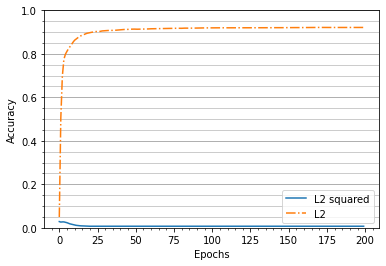

In [29]:
# plotting accuracys of global models
set_styles()
plt.ylim([0,1])
plt.grid(True, which='major', linewidth=1, axis='y', alpha=1)
plt.minorticks_on()
plt.grid(True, which='minor', linewidth=0.8, axis='y', alpha=0.8)
plt.plot(hist_l2_squared[3], label='L2 squared', linestyle=next(STYLES))
plt.plot(hist_l2[3], label='L2', linestyle=next(STYLES))
plt.savefig('glob_accs.pdf', bbox_inches='tight')
legendize('Accuracy')
title_save(title='', path='glob_accs', suff='.pdf')

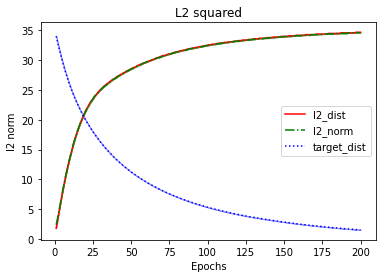

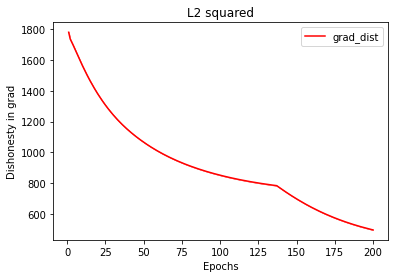

In [21]:
# training metrics for L2 squared
plot_metrics([hist_l2_squared], title='L2 squared', path='l2squared_')

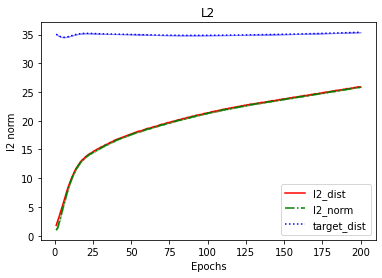

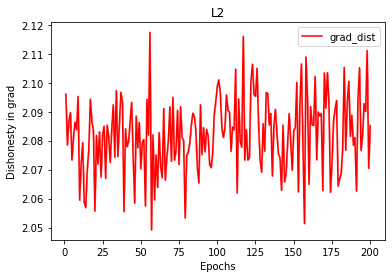

In [22]:
# training metrics for L2
plot_metrics([hist_l2], title='L2', path='l2_')